In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 5) remove checkpoints
# import os; _ = [os.remove(p) for p in __import__("glob").glob("libs/.ipynb_checkpoints/*.py") if os.path.exists(p)]

import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

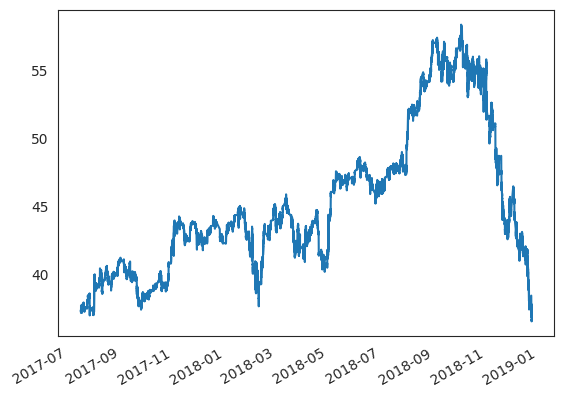

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_9,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,psar_dir,vwap_ohlc_close_session
2017-07-17 08:04:00,37.300000,37.300000,37.300000,37.300000,2400.000000,2.000000,149.200000,37.307450,37.292550,0.001275,0.001274,37.265000,0.000939,37.261944,0.001021,37.257726,0.001135,37.262775,0.000999,37.261963,0.001021,37.260491,0.001060,37.264829,37.260688,37.261018,0.001074,0.001265,0.001154,0.0,0.0,0.0,0.0,0.0,89.668946,83.917085,78.722993,0.005994,0.002121,0.003873,0.002454,-0.000669,0.003123,0.008047,0.000216,0.004502,0.000121,0.003207,0.000086,88.901002,11.093819,56.014570,83.593040,15.981423,36.927554,68.749931,24.186415,15.217115,37.237862,37.277700,0.001069,37.227903,37.287660,0.001604,37.243960,37.281590,0.001010,4.435695e+09,2.391119,3.350618,4.291133,37.33,37.215,0.000804,0.002279,2154.000000,57.804443,-1659.200000,-44.533045,0.000282,0.000174,100.000000,44.444444,100.000000,44.444444,430.266667,575.873828,47.423896,36.894338,0.000000,0.000000,37.3000,37.2525,0.001273,37.3000,37.2525,0.001273,37.264460,37.264327,0.000731,-0.000368,37.260791,37.255432,37.266149,0.000288,37.260791,37.253646,37.267935,0.000383,37.252500,1,37.300000
2017-07-17 08:05:00,37.299554,37.299554,37.299554,37.299554,2381.428571,2.035714,149.198214,37.307004,37.292104,-0.000012,-0.000012,37.272911,0.000715,37.266895,0.000876,37.259770,0.001068,37.263266,0.000974,37.262358,0.000998,37.260707,0.001043,37.271774,37.264221,37.262529,0.001062,0.001263,0.001152,0.0,0.0,0.0,0.0,0.0,88.809157,83.280060,78.212861,0.009585,0.004609,0.004976,0.005197,0.000504,0.004693,0.006961,0.000187,0.004212,0.000113,0.003108,0.000083,88.086535,11.908333,58.895647,82.960215,16.617469,39.048736,68.397295,24.575282,16.357016,37.232992,37.286901,0.001447,37.219515,37.300378,0.002170,37.242069,37.284463,0.001138,4.435693e+09,1.892720,2.776337,3.780468,37.33,37.215,0.000816,0.002267,-827.428572,-22.201391,-3638.428572,-97.650322,0.000282,0.000174,99.060150,66.353383,99.060150,66.353383,231.951214,330.797912,38.400395,31.195063,0.000000,0.000000,37.3000,37.2525,0.001273,37.3000,37.2525,0.001273,37.270486,37.265157,0.001303,-0.000251,37.264482,37.259358,37.269606,0.000275,37.264482,37.257650,37.271314,0.000367,37.252500,1,37.299778
2017-07-17 08:06:00,37.299107,37.299107,37.299107,37.299107,2362.857143,2.071429,149.196429,37.306557,37.291657,-0.000012,-0.000012,37.281232,0.000479,37.271518,0.000740,37.261811,0.001001,37.263748,0.000949,37.262749,0.000976,37.260878,0.001026,37.277240,37.267393,37.263963,0.001117,0.001184,0.001150,0.0,0.0,0.0,0.0,0.0,87.798928,82.604762,77.684290,0.011328,0.006848,0.004479,0.007252,0.001854,0.005399,0.006031,0.000162,0.003943,0.000106,0.003013,0.000081,87.154986,12.839937,61.098958,82.289340,17.291759,40.921755,68.035400,24.974360,17.426313,37.230308,37.293908,0.001707,37.214408,37.309808,0.002560,37.240507,37.286989,0.001247,4.435690e+09,1

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds_trainval = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds_trainval = df_inds_trainval[(df_inds_trainval.index >= '2017-07-15') & (df_inds_trainval.index < '2018-12-25')] #########################
# df_inds_trainval = df_inds_trainval[df_inds_trainval.index.to_period("M") == params.month_to_check] ################################

# # compute synthetic ask/bid from close_raw and configured spread
# df_inds_trainval['ask'] = df_inds_trainval['close'] * (1 + params.bidask_spread_pct/100)
# df_inds_trainval['bid'] = df_inds_trainval['close'] * (1 - params.bidask_spread_pct/100)

df = df_inds_trainval # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
trading_combinations = {
    # EMA based
     # "tc_ema_3_8":     {"col_signal": "ema_3",    "sign_thresh": "ema_8"},
    # "tc_ema_5_13":   {"col_signal": "ema_5",    "sign_thresh": "ema_13"},
    "tc_ema_9_21":   {"col_signal": "ema_9",    "sign_thresh": "ema_21"},
    "tc_ema_21_50":  {"col_signal": "ema_21",    "sign_thresh": "ema_50"},
    # ROC based
    "tc_roc5_ema21": {"col_signal": "roc_5",    "sign_thresh": "ema_21"},
    "tc_roc5_zero":  {"col_signal": "roc_5",    "sign_thresh": 0.0},
    # MACD-based:
    "tc_macd_line":  {"col_signal": "macd_line_12_26_9", "sign_thresh": 0.0},
    "tc_macd_diff":  {"col_signal": "macd_diff_6_13_5",  "sign_thresh": 0.0},
    # RSI gate as signal:
    "tc_rsi_mid":    {"col_signal": "rsi_14",   "sign_thresh": 50.0},
    "tc_rsi_fast":   {"col_signal": "rsi_6",    "sign_thresh": 50.0},

}

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    
    trad_comb = trading_combinations[
        trial.suggest_categorical("tc_id", list(trading_combinations.keys()))
    ]
    
    reset_peak     = trial.suggest_categorical("reset_peak", [True, False])
    
    # RSI band
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 3, 70)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", rsi_min_thresh + 1, 100)
    # Volume spike threshold (ratio-ish)
    vol_thresh     = trial.suggest_float("vol_thresh", 0.3, 6.0)
    # Trend filter
    adx_thresh     = trial.suggest_float("adx_thresh", 5.0, 50.0)
    # ATR multipliers (log for breadth)
    atr_mult       = trial.suggest_float("atr_mult", 0.3, 10.0, log=True)
    # VWAP+ATR gate; allow negative/positive tilt
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -5.0, 5.0)
    # Scaling factors (wire these into your strategy if used)
    buy_factor     = trial.suggest_float("buy_factor", 0.0, 1.0)
    sell_factor    = trial.suggest_float("sell_factor", 0.0, 1.0)
    # Trailing stop percentage (as percent; kept wider but sane)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.2, 20.0)
    # Session start choice
    sess_start = time.fromisoformat(
        trial.suggest_categorical(
            "sess_start",
            [params.sess_premark.isoformat(), params.sess_start_reg.isoformat()],
        )
    )
    
    print('-' * 150)
    print(f"Params => trad_comb={trad_comb}, reset_peak={reset_peak}, rsi_min_thresh={rsi_min_thresh:.5f}, rsi_max_thresh={rsi_max_thresh:.5f}, atr_mult={atr_mult:.5f}, vwap_atr_mult={vwap_atr_mult:.5f}, buy_factor={buy_factor:.5f}, sell_factor={sell_factor:.5f}, trailstop_pct={trailstop_pct:.5f}, sess_start={sess_start}")
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strategies.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_actions_alpaca(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = "atr_14",
            col_adx         = "adx_14",
            col_vol_spike   = 'vol_spike_14',
            col_rsi         = "rsi_6",
            col_vwap        = "vwap_ohlc_close_session",
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            sess_start      = sess_start
        )

        sim_results = strategies.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
            sess_start      = sess_start
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strategies._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strategies._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)




Baseline mean daily B&H: -4.6186
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rsi_14', 'sign_thresh': 50.0}, reset_peak=True, rsi_min_thresh=38.00000, rsi_max_thresh=62.00000, atr_mult=1.41847, vwap_atr_mult=-4.91629, buy_factor=0.46467, sell_factor=0.66058, trailstop_pct=7.14017, sess_start=13:30:00


Trial 0: 100%|██████████| 364/364 [00:58<00:00,  6.25it/s]


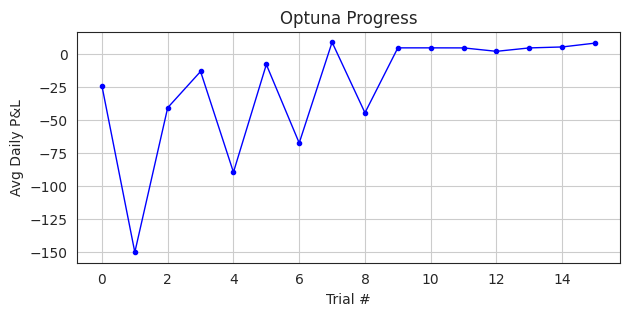

[Results] mean_pnl:-28.9492 mean_excess:-24.0448 improv:390.27%
Action counts: {'Buy': 651, 'Sell': 2543, 'Hold': 331620}
Best trial is: 0 with best_val: -24.0448
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff_6_13_5', 'sign_thresh': 0.0}, reset_peak=False, rsi_min_thresh=33.00000, rsi_max_thresh=64.00000, atr_mult=0.41854, vwap_atr_mult=-0.78256, buy_factor=0.10943, sell_factor=0.72573, trailstop_pct=8.99032, sess_start=08:00:00


Trial 1: 100%|██████████| 364/364 [00:53<00:00,  6.79it/s]


[Results] mean_pnl:-155.3927 mean_excess:-150.4883 improv:2968.42%
Action counts: {'Buy': 1210, 'Sell': 1210, 'Hold': 332394}
Best trial is: 0 with best_val: -24.0448
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_diff_6_13_5', 'sign_thresh': 0.0}, reset_peak=True, rsi_min_thresh=21.00000, rsi_max_thresh=41.00000, atr_mult=0.71440, vwap_atr_mult=0.03915, buy_factor=0.46698, sell_factor=0.57314, trailstop_pct=12.83874, sess_start=08:00:00


Trial 2: 100%|██████████| 364/364 [00:29<00:00, 12.22it/s]


[Results] mean_pnl:-45.5033 mean_excess:-40.5989 improv:727.80%
Action counts: {'Buy': 247, 'Sell': 247, 'Hold': 334320}
Best trial is: 0 with best_val: -24.0448
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_5', 'sign_thresh': 0.0}, reset_peak=True, rsi_min_thresh=3.00000, rsi_max_thresh=16.00000, atr_mult=2.62281, vwap_atr_mult=-4.73484, buy_factor=0.88742, sell_factor=0.67942, trailstop_pct=7.68509, sess_start=13:30:00


Trial 3: 100%|██████████| 364/364 [00:23<00:00, 15.19it/s]


[Results] mean_pnl:-17.9488 mean_excess:-13.0444 improv:165.97%
Action counts: {'Buy': 194, 'Sell': 189, 'Hold': 334431}
Best trial is: 3 with best_val: -13.0444
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_21', 'sign_thresh': 'ema_50'}, reset_peak=False, rsi_min_thresh=19.00000, rsi_max_thresh=37.00000, atr_mult=2.51989, vwap_atr_mult=2.42480, buy_factor=0.42432, sell_factor=0.34146, trailstop_pct=17.78513, sess_start=08:00:00


Trial 4: 100%|██████████| 364/364 [00:29<00:00, 12.37it/s]


[Results] mean_pnl:-94.5664 mean_excess:-89.6620 improv:1728.19%
Action counts: {'Buy': 2587, 'Sell': 12596, 'Hold': 319631}
Best trial is: 3 with best_val: -13.0444
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=False, rsi_min_thresh=26.00000, rsi_max_thresh=59.00000, atr_mult=0.50581, vwap_atr_mult=-0.57278, buy_factor=0.29559, sell_factor=0.81627, trailstop_pct=6.35376, sess_start=08:00:00


Trial 5: 100%|██████████| 364/364 [00:33<00:00, 10.83it/s]


[Results] mean_pnl:-12.6514 mean_excess:-7.7470 improv:57.96%
Action counts: {'Buy': 278, 'Sell': 865, 'Hold': 333671}
Best trial is: 5 with best_val: -7.7470
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rsi_6', 'sign_thresh': 50.0}, reset_peak=True, rsi_min_thresh=14.00000, rsi_max_thresh=64.00000, atr_mult=8.31006, vwap_atr_mult=-3.36825, buy_factor=0.48641, sell_factor=0.77003, trailstop_pct=0.87630, sess_start=13:30:00


Trial 6: 100%|██████████| 364/364 [00:26<00:00, 13.77it/s]


[Results] mean_pnl:-72.3461 mean_excess:-67.4417 improv:1275.12%
Action counts: {'Buy': 1588, 'Sell': 3852, 'Hold': 329374}
Best trial is: 5 with best_val: -7.7470
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_21', 'sign_thresh': 'ema_50'}, reset_peak=True, rsi_min_thresh=46.00000, rsi_max_thresh=80.00000, atr_mult=6.17296, vwap_atr_mult=2.37224, buy_factor=0.17068, sell_factor=0.16490, trailstop_pct=19.07755, sess_start=13:30:00


Trial 7: 100%|██████████| 364/364 [00:25<00:00, 14.00it/s]


[Results] mean_pnl:4.2856 mean_excess:9.1900 improv:-287.38%
Action counts: {'Buy': 98, 'Sell': 1889, 'Hold': 332827}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'rsi_14', 'sign_thresh': 50.0}, reset_peak=False, rsi_min_thresh=62.00000, rsi_max_thresh=95.00000, atr_mult=0.91658, vwap_atr_mult=0.85415, buy_factor=0.41404, sell_factor=0.94008, trailstop_pct=15.45184, sess_start=08:00:00


Trial 8: 100%|██████████| 364/364 [00:23<00:00, 15.32it/s]


[Results] mean_pnl:-49.3756 mean_excess:-44.4712 improv:806.76%
Action counts: {'Buy': 953, 'Sell': 1378, 'Hold': 332483}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=17.00000, rsi_max_thresh=49.00000, atr_mult=1.71027, vwap_atr_mult=0.01828, buy_factor=0.07484, sell_factor=0.87831, trailstop_pct=1.98151, sess_start=13:30:00


Trial 9: 100%|██████████| 364/364 [00:19<00:00, 18.75it/s]


[Results] mean_pnl:0.0026 mean_excess:4.9070 improv:-200.05%
Action counts: {'Buy': 14, 'Sell': 36, 'Hold': 334764}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'roc_5', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=53.00000, rsi_max_thresh=88.00000, atr_mult=8.94230, vwap_atr_mult=4.56067, buy_factor=0.72745, sell_factor=0.06888, trailstop_pct=18.79452, sess_start=13:30:00


Trial 10: 100%|██████████| 364/364 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:0.0000 mean_excess:4.9044 improv:-200.00%
Action counts: {'Buy': 0, 'Sell': 0, 'Hold': 334814}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_21', 'sign_thresh': 'ema_50'}, reset_peak=True, rsi_min_thresh=48.00000, rsi_max_thresh=81.00000, atr_mult=4.15934, vwap_atr_mult=2.47593, buy_factor=0.00210, sell_factor=0.34747, trailstop_pct=0.55791, sess_start=13:30:00


Trial 11: 100%|██████████| 364/364 [00:27<00:00, 13.48it/s]


[Results] mean_pnl:-0.0289 mean_excess:4.8755 improv:-199.41%
Action counts: {'Buy': 14, 'Sell': 48, 'Hold': 334752}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'macd_line_12_26_9', 'sign_thresh': 0.0}, reset_peak=True, rsi_min_thresh=69.00000, rsi_max_thresh=98.00000, atr_mult=4.54304, vwap_atr_mult=2.40565, buy_factor=0.19911, sell_factor=0.02075, trailstop_pct=11.84210, sess_start=13:30:00


Trial 12: 100%|██████████| 364/364 [00:25<00:00, 14.39it/s]


[Results] mean_pnl:-2.6423 mean_excess:2.2621 improv:-146.12%
Action counts: {'Buy': 11, 'Sell': 11, 'Hold': 334792}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=41.00000, rsi_max_thresh=77.00000, atr_mult=1.35912, vwap_atr_mult=-2.34769, buy_factor=0.00671, sell_factor=0.24609, trailstop_pct=3.71156, sess_start=13:30:00


Trial 13: 100%|██████████| 364/364 [00:21<00:00, 16.58it/s]


[Results] mean_pnl:-0.0442 mean_excess:4.8602 improv:-199.10%
Action counts: {'Buy': 45, 'Sell': 331, 'Hold': 334438}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_9', 'sign_thresh': 'ema_21'}, reset_peak=True, rsi_min_thresh=7.00000, rsi_max_thresh=46.00000, atr_mult=4.79263, vwap_atr_mult=4.26101, buy_factor=0.25284, sell_factor=0.47627, trailstop_pct=14.58592, sess_start=13:30:00


Trial 14: 100%|██████████| 364/364 [00:20<00:00, 17.74it/s]


[Results] mean_pnl:0.6898 mean_excess:5.5942 improv:-214.07%
Action counts: {'Buy': 48, 'Sell': 342, 'Hold': 334424}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_21', 'sign_thresh': 'ema_50'}, reset_peak=True, rsi_min_thresh=3.00000, rsi_max_thresh=25.00000, atr_mult=5.18976, vwap_atr_mult=4.62122, buy_factor=0.26246, sell_factor=0.45328, trailstop_pct=15.76485, sess_start=13:30:00


Trial 15: 100%|██████████| 364/364 [00:21<00:00, 16.74it/s]


[Results] mean_pnl:3.6175 mean_excess:8.5219 improv:-273.76%
Action counts: {'Buy': 56, 'Sell': 395, 'Hold': 334363}
Best trial is: 7 with best_val: 9.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => trad_comb={'col_signal': 'ema_21', 'sign_thresh': 'ema_50'}, reset_peak=True, rsi_min_thresh=50.00000, rsi_max_thresh=85.00000, atr_mult=6.36392, vwap_atr_mult=3.78866, buy_factor=0.28332, sell_factor=0.19370, trailstop_pct=19.73875, sess_start=13:30:00


Trial 16:   2%|▏         | 7/364 [00:00<00:37,  9.40it/s]

In [ ]:
importlib.reload(strategies)
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1 # must be always 1, otherwise global variables don´t reset correctly ?

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

start = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
end   = df.loc[df.index.normalize() == df.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

def short_log_callback(study, trial):
    val = trial.value # mean_excess
    mean_pnl = trial.user_attrs["mean_pnl"]
    mean_bh_pnls = trial.user_attrs["mean_bh_pnls"]
    pct_improv = (val/mean_bh_pnls -1) * 100
    action_counts = trial.user_attrs["action_counts"]
    print( f"[Results] mean_pnl:{mean_pnl:.4f} mean_excess:{val:.4f} improv:{pct_improv:.2f}%\n"
          f"Action counts: {action_counts}\n" 
          f"Best trial is: {study.best_trial.number} with best_val: {study.best_value:.4f}" )

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=trials_before_pruning, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")